In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

#Load two blood datasets
data1 =  pd.read_csv('./Haematopoiesis/logDataF3.csv', index_col=0)
data2  = pd.read_csv('./Haematopoiesis/logDataA3.csv', index_col=0)

#combine two dataset and obtain PCs
pca = PCA(20)
pca50 = pca.fit_transform(np.vstack([data1.T, data2.T]))
pca50 = pca50/pca50[:,0].std()


In [2]:
#install seaborn for plotting if you don't have it installed
#!pip install seaborn

In [3]:
#process cell type annotations following original MNN manuscript code

anno1 = np.array(data1.columns)
anno2 = np.array(data2.columns)

anno1 = [ a.split('.')[0] for a in anno1]
anno2 = [ a.split('.')[0] for a in anno2]

anno1 = ["Unsorted" if a == "other" else a for a in anno1]
anno2 = ["MEP" if a == "ERY" else a for a in anno2]

In /home2/s190483/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home2/s190483/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home2/s190483/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


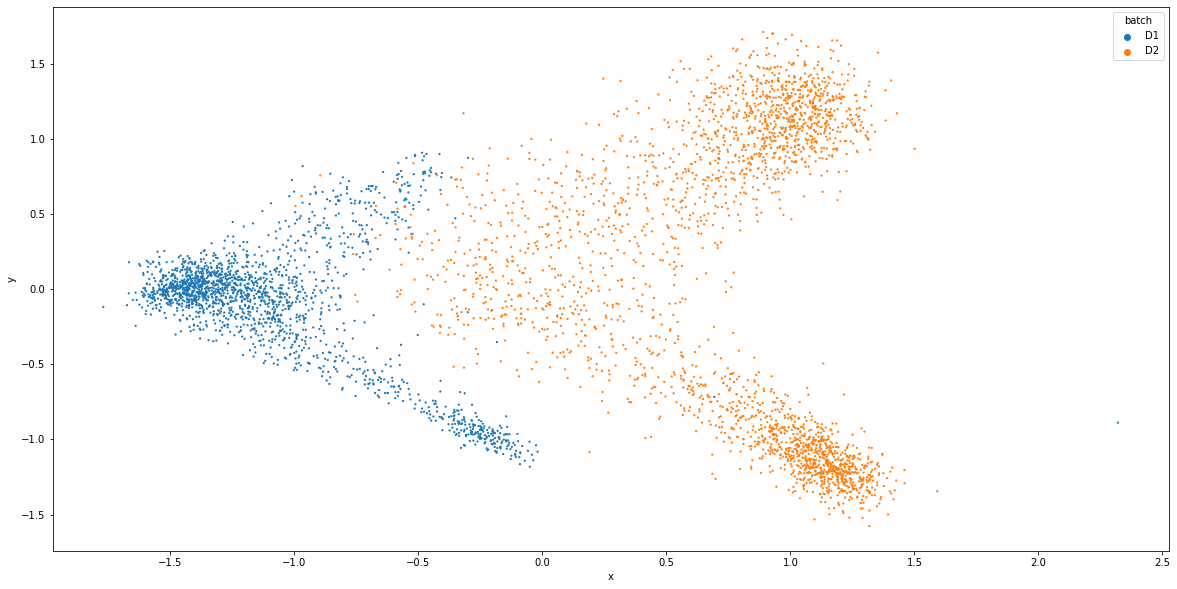

In [4]:
import seaborn
import warnings
from matplotlib import pyplot as plt
%matplotlib inline
warnings.simplefilter("ignore")

plotdata = pd.concat([pd.DataFrame({'x':pca50[:data1.shape[1],0], 
                                    'y':pca50[:data1.shape[1],1], 
                                    'batch': 'D1'}),
                   pd.DataFrame({'x':pca50[data1.shape[1]:,0], 
                                 'y':pca50[data1.shape[1]:,1], 
                                 'batch': 'D2'})], axis=0)
plt.figure(figsize=(20,10))
seaborn.scatterplot(x=plotdata['x'], y=plotdata['y'], linewidth = 0, s=5, hue=plotdata['batch'])



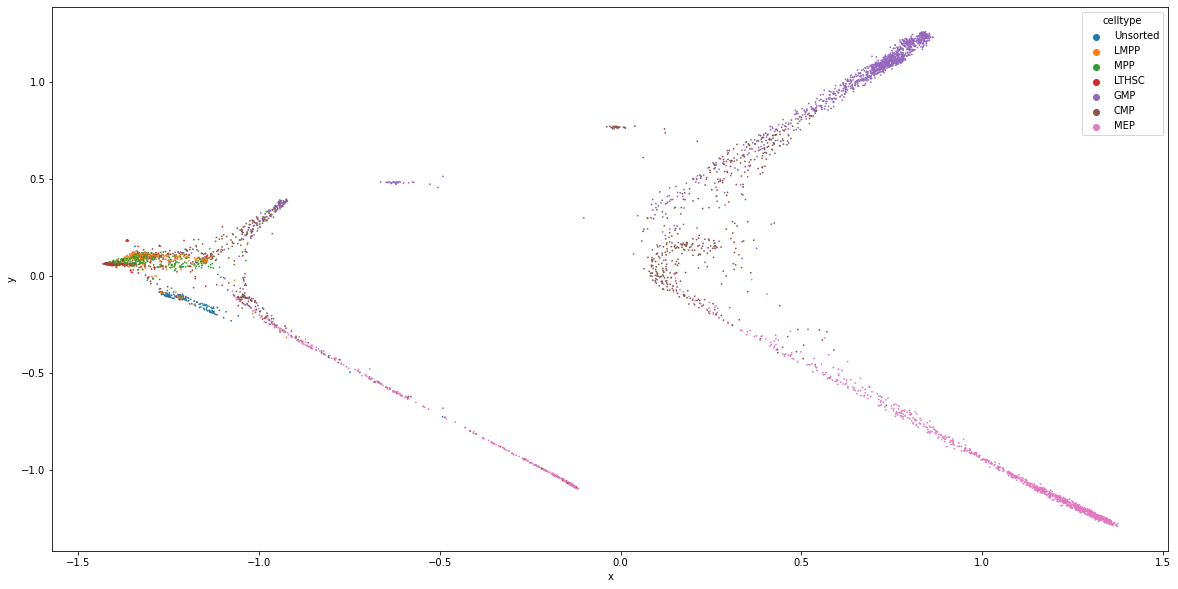

In [5]:
#Directly apply GraphDR does not merge two datasets

dr1 = graphdr(pca50[:data1.shape[1],:], 
              n_neighbors=20, 
              regularization=1000,
              refine_iter=0,
              no_rotation=True,
              rescale=True)

dr2 = graphdr(pca50[data1.shape[1]:,:], 
              n_neighbors=20, 
              regularization=1000,
              refine_iter=0,
              no_rotation=True,
              rescale=True)


plotdata = pd.concat([pd.DataFrame({'x':dr1[:,0], 'y':dr1[:,1], 'batch': 'D1', 'celltype': anno1}),
                   pd.DataFrame({'x':dr2[:,0], 'y':dr2[:,1], 'batch': 'D2', 'celltype': anno2})], axis=0)
plt.figure(figsize=(20,10))
seaborn.scatterplot(x=plotdata['x'], y=plotdata['y'], linewidth = 0, s=3, hue=plotdata['celltype'])


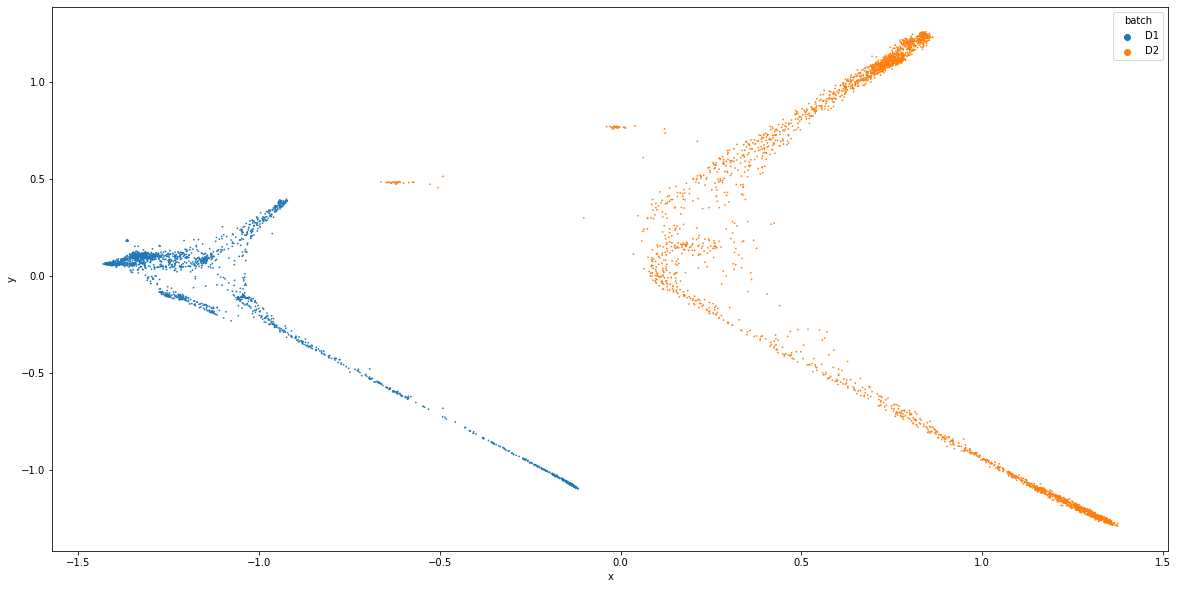

In [6]:
plt.figure(figsize=(20,10))
seaborn.scatterplot(x=plotdata['x'], y=plotdata['y'], linewidth = 0, s=3, hue=plotdata['batch'])


In [7]:
#example of generating graph for batch design dataset
#optional task for you: incorporate this capability to your graphdr implementation 
#i.e. automatcally generate such graph given input of batch information


from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import kneighbors_graph
m='euclidean'
data_batch = np.concatenate([np.repeat('F',data1.shape[1]),np.repeat('A',data2.shape[1])])

k=50

nn_batch={}
batchs = np.unique(data_batch)
for s in batchs:
    nn_batch[s]=NearestNeighbors(k,metric=m).fit(pca50[data_batch==s,:])

#source_id
s=[]
#target_id
t=[]
#edge_weight
w=[]
for i in range(len(batchs)):
    for j in range(len(batchs)):
        if i!=j:
            dis, ind = nn_batch[batchs[i]].kneighbors(pca50[data_batch==batchs[j],:], k)
            s.append(np.repeat(np.argwhere(data_batch==batchs[j]), ind.shape[1]))
            t.append(np.argwhere(data_batch==batchs[i])[ind].flatten())
            w.append(np.ones(k*np.sum(data_batch==batchs[j])))

#nearest neighbor graph across batches
g = csr_matrix((np.concatenate(w),(np.concatenate(s).astype(np.int),np.concatenate(t).astype(np.int))),
               (pca50.shape[0], pca50.shape[0]))

#regular nearest neighbor graph
g0 = kneighbors_graph(pca50, n_neighbors=20)

#mutual nearest neighbor graph across batches + regular nearest neighbor graph
g1 = g.multiply(g.T)+g0

In [8]:
#call your graphdr with batch effect handled here 
#dr_integrated = graphdr(...)
dr_integrated1 = dr_integrated[:data1.shape[1],:]
dr_integrated2 = dr_integrated[data1.shape[1]:,:]

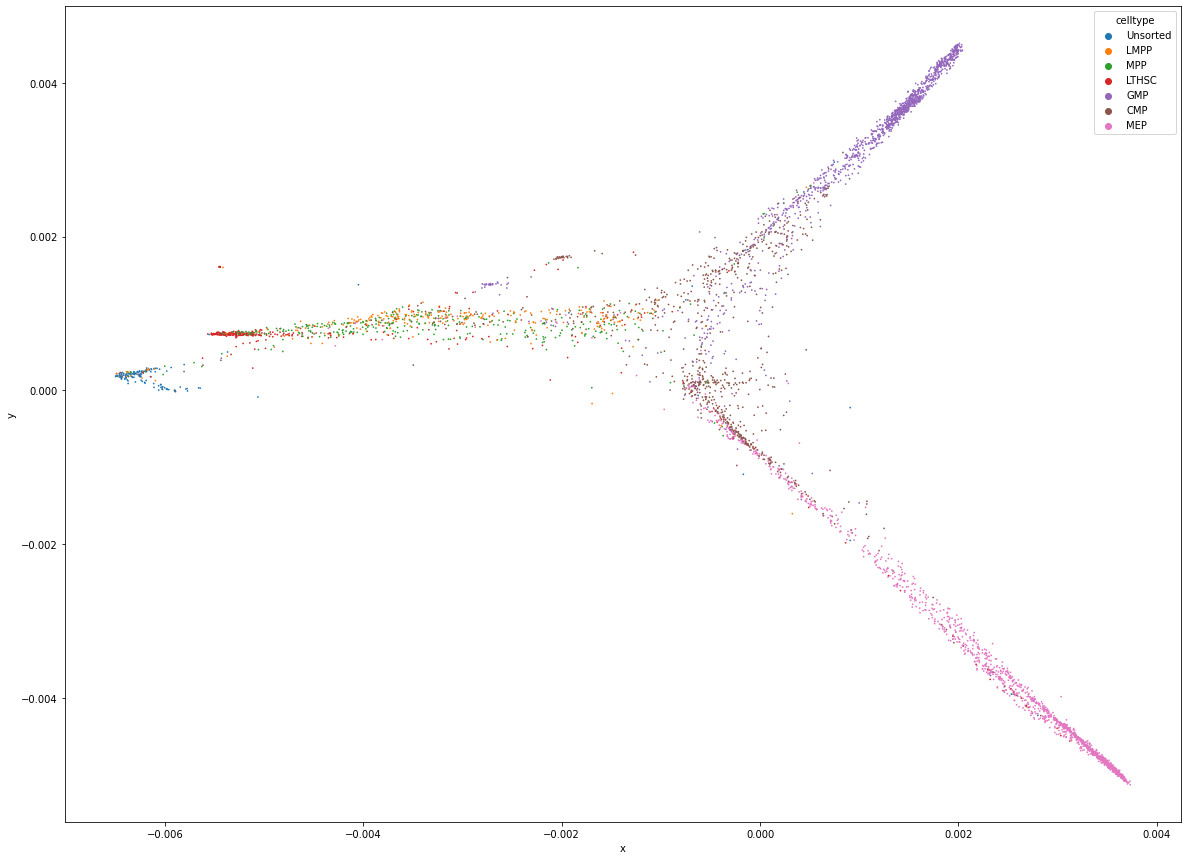

In [9]:
#example output
plotdata = pd.concat([pd.DataFrame({'x':dr_integrated1[:,0], 'y':dr_integrated1[:,1], 'batch': 'D1', 'celltype': anno1}),
                   pd.DataFrame({'x':dr_integrated2[:,0], 'y':dr_integrated2[:,1], 'batch': 'D2', 'celltype': anno2})], axis=0)

plt.figure(figsize=(20,15))
seaborn.scatterplot(x=plotdata['x'], y=plotdata['y'], linewidth = 0, s=3, hue=plotdata['celltype'])


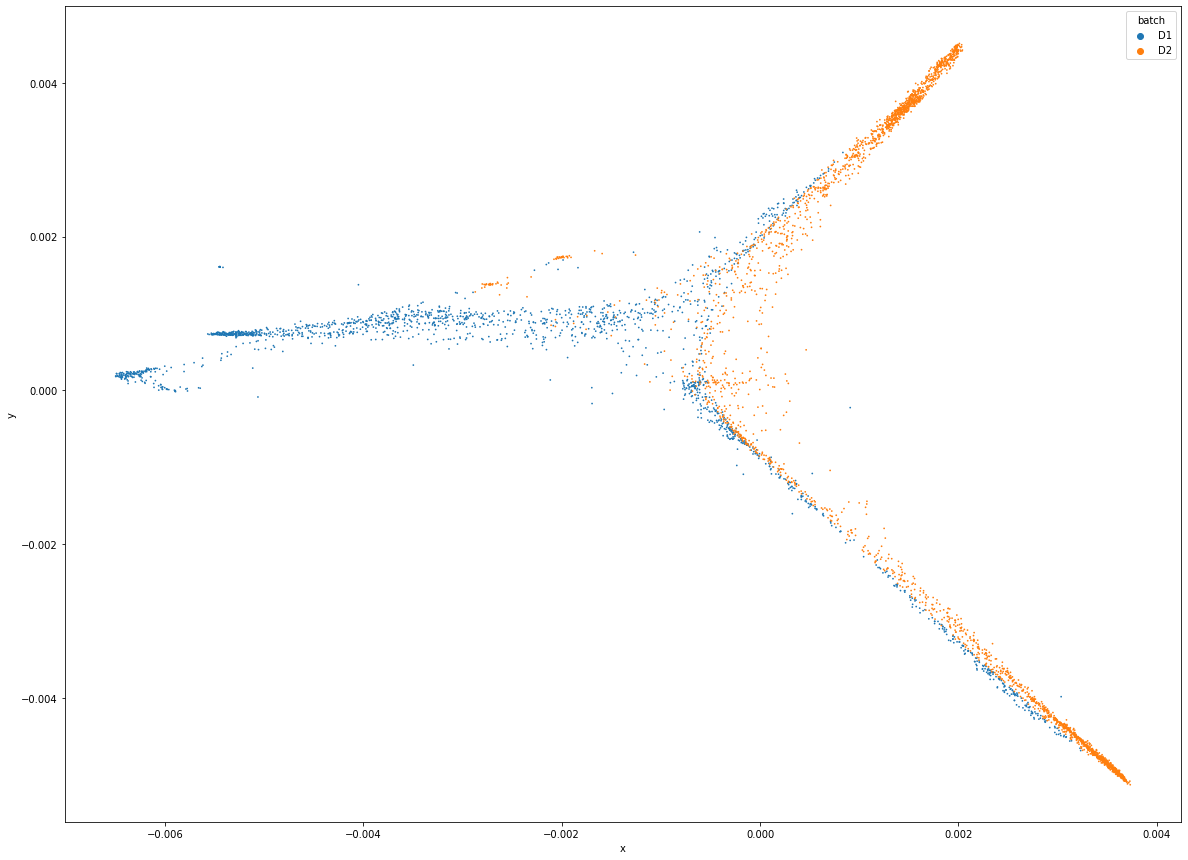

In [10]:
plt.figure(figsize=(20,15))
seaborn.scatterplot(x=plotdata['x'], y=plotdata['y'], linewidth = 0, s=3, hue=plotdata['batch'])